# Import Packages and functions

C:\Users\CLMRX\OneDrive - COWI\Documents\GitHub\CRVA_tool\FunctionsAndClass.py:12: UserWarning: Shapely 2.0 is installed, but because PyGEOS is also installed, GeoPandas will still use PyGEOS by default for now. To force to use and test Shapely 2.0, you have to set the environment variable USE_PYGEOS=0. You can do this before starting the Python process, or in your code before importing geopandas:

import os
os.environ['USE_PYGEOS'] = '0'
import geopandas

In a future release, GeoPandas will switch to using Shapely by default. If you are using PyGEOS directly (calling PyGEOS functions on geometries from GeoPandas), this will then stop working and you are encouraged to migrate from PyGEOS to Shapely 2.0 (https://shapely.readthedocs.io/en/latest/migration_pygeos.html).
  import geopandas as gpd


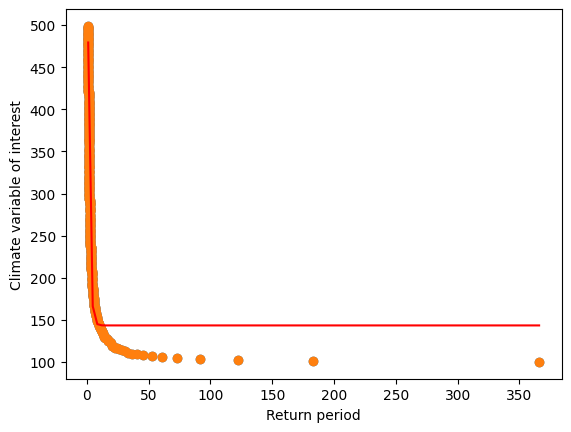

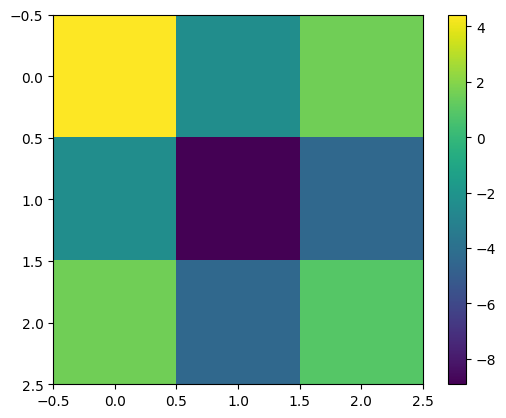

In [1]:
import requests
import pandas as pd

import os
import os.path

from netCDF4 import Dataset

import xarray as xr

import numpy as np
import numpy.ma as ma

# to measure elapsed time
import time
from timeit import default_timer as timer

import multiprocessing as mp# to download several file in parrallel
from multiprocessing.pool import ThreadPool

from FileManagement1 import produce_name_list
from FunctionsAndClass import year_copernicus
from FileManagement1 import find_path_file
from FileManagement1 import find_column_name
from FileManagement1 import time_vector_conversion
from FileManagement1 import data_information
from FileManagement1 import df_to_csv
from FileManagement1 import read_nc_file

# Projects information


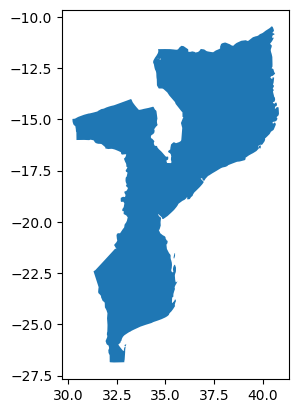

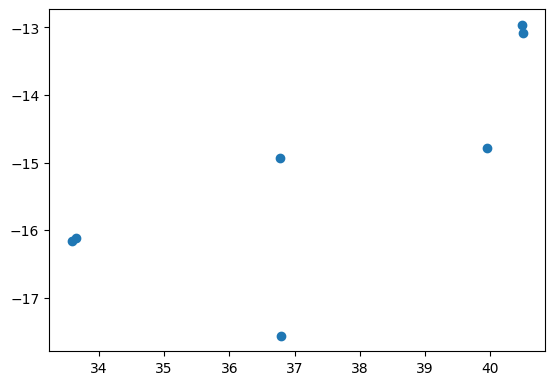

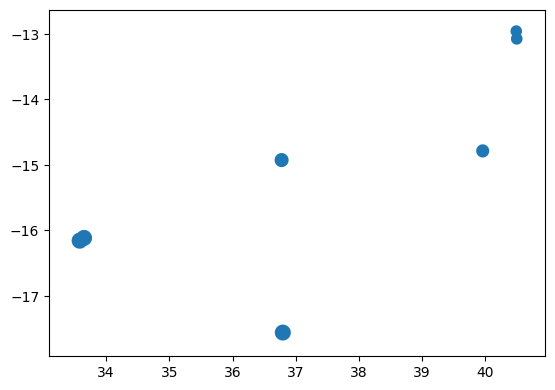

In [2]:
import geopandas as gpd
import os
import os.path

data_folder=r'\\COWI.net\projects\A245000\A248363\CRVA\Datasets'
project_location_path=os.path.join(data_folder,'Mozambique_PPIS/EIB_locations_few.shp')
#study boundary (optional)
study_area_path=os.path.join(data_folder,'Mozambique_PPIS/mozambique.shp')


#projection CRS (default = 'EPSG:4326')
bCRS='EPSG:4326'

#buffer for climate/grid variables
buffer=40000 #buffer in meters, 0 = no buffer is computed

mCRS='EPSG:31983' #metric CRS for buffer in meters (find relevant metric CRS for location!)

#load shapefiles
projects = gpd.read_file(project_location_path).to_crs(bCRS)
project_id='Name' #name of column used as id

study_area = gpd.read_file(study_area_path).to_crs(bCRS)

#calculate buffer around points/shape
if buffer != 0:
    projects_buf=projects.to_crs(mCRS)  #project to crs with metric units to get buffer in meters
    projects_buf['geometry']=projects.to_crs(mCRS).buffer(buffer) #assign the buffer as the new geometry - 
    projects_buf=projects_buf.to_crs(bCRS)#project back to orginal crs

    
#plot shapefiles
study_area.plot()
projects.plot()
projects_buf.plot() 


#show table
projects[[project_id]]
# prepare name_project for use 
name_project = projects['Name'].str.replace(' ','_') # take off every blank space of project names
name_project = name_project.str.replace('(','') # take off every ( of project names
name_project = name_project.str.replace(')','') # take off every ) of project names
name_project = name_project.str.replace('-','') # take off every - of project names
name_project = name_project.str.replace('/','_') # take off every / of project names
name_project = name_project.str.replace(r'"\"','_') # take off every \ of project names

# register geographic information concerning projects
lon_projects = projects['geometry'].x
lat_projects = projects['geometry'].y
buf_projects = 0.3
area_projects = [lat_projects - buf_projects, lat_projects+buf_projects, lon_projects-buf_projects,lon_projects+buf_projects] # list format
#### determination of the geographical zone of interest 
lat_min_wanted = min(study_area['LAT'])-10
lat_max_wanted = max(study_area['LAT'])+10
lon_min_wanted = min(study_area['LON'])-20
lon_max_wanted = max(study_area['LON'])+20
# addind and substracting to lon and lat to have margin
# substracting more to longitude because the range of longitude is -180 to 180. The range of latitude is -90 to 90

In [3]:
len(lon_projects)

7

In [4]:
lon_projects

0    33.651626
1    33.582722
2    39.956305
3    36.776066
4    36.795077
5    40.487087
6    40.494835
dtype: float64

# Define Paths

In [5]:
out_path=r'\\COWI.net\projects\A245000\A248363\CRVA\Datasets\NEX-GDDP-CMIP6'

# Complete list of url with files to download

In [6]:
# register information from csv file
#all_urls = pd.read_csv(r'C:\Users\CLMRX\OneDrive - COWI\Documents\GitHub\CRVA_tool\outputs\NEX-GDDP-CMIP6\gddp-cmip6-thredds-fileserver.csv')
csv_path = os.path.join(out_path,'gddp-cmip6-thredds-fileserver.csv')
all_urls = pd.read_csv(csv_path)

In [7]:
### make all elements of the csv into a readable list

temp_list = all_urls[[' fileUrl']].T# transpose csv
temp_list=temp_list.values.tolist()
temp_list=temp_list[0]
url_list=[s.replace(' ', '') for s in temp_list]

In [8]:
## download only precipitation data
# select only precipitation files, between 2040 and 2080
url_list_precipitation = [url for url in url_list if 'pr_day_' in url and int(url[len(url)-7:len(url)-3])>2020 and int(url[len(url)-7:len(url)-3])<2061 and 'r1i1p1f1_gn' in url]

In [9]:
len(url_list_precipitation)

2360

In [10]:
name_list_precipitation = produce_name_list(url_list_precipitation)

# Produce csv files with data to use

In [11]:
(year, year_str, index_year) = year_copernicus(2021,2022)

In [ ]:
variables= []
time_aggregations= []
models= []
scenarios= []
for file_name in name_list_precipitation:
    (variable, time_aggregation, model, scenario, year) = data_information(file_name) 
    # use function data_information to find information concerning the file_name
    if variable not in variables:
        variables.append(variable)
    if time_aggregation not in time_aggregations:
        time_aggregations.append(time_aggregation)
    if model not in models:
        models.append(model)
    if scenario not in scenarios:
        scenarios.append(scenario)
title_file = variable +'_'+year_str[0] +'_'+year_str[len(year_str)-1]
name_variable = 'pr_day'

In [ ]:
# count time

In [ ]:
i = 0
df = pd.DataFrame() # create an empty dataframe
title_file = name_project[i]+'_2021-2022'+'.csv'
#area_project = [area_projects[0][i],area_projects[1][i],area_projects[2][i],area_projects[3][i]]
start = timer()
df=create_dataframe(name_list_precipitation,'daily',year_str,[scenarios[0]],[models[0]],out_path, name_variable, name_project[i],lon_projects[0],lat_projects[0],df)
# return df and final path of csv
path_csv = df_to_csv(df,out_path,title_file,name_variable,'2021-2022')
end = timer()
print('----- Time to execute the function create_dataframe with one model and one scenario: ' + str(end - start) +' seconds -------- ')
print('\n')

In [ ]:
(year, year_str, index_year) = year_copernicus(2040,2050)

In [ ]:
variables= []
time_aggregations= []
models= []
scenarios= []
for file_name in name_list_precipitation:
    (variable, time_aggregation, model, scenario, year) = data_information(file_name) 
    # use function data_information to find information concerning the file_name
    if variable not in variables:
        variables.append(variable)
    if time_aggregation not in time_aggregations:
        time_aggregations.append(time_aggregation)
    if model not in models:
        models.append(model)
    if scenario not in scenarios:
        scenarios.append(scenario)
#title_file = variable +'_'+year_str[0] +'_'+year_str[len(year_str)-1]
name_variable = 'pr_day'

In [ ]:
variables

In [ ]:
len(scenarios)

In [ ]:
len(models)

In [ ]:
df = pd.DataFrame() # create an empty dataframe
start = time.time()
title_file = 'All_projects_moz_precipitation_2040-2050.csv'
for i in np.arange(0,len(name_project)):
    df=create_dataframe(name_list_precipitation,'daily',year_str,scenarios,models,out_path, name_variable, name_project[i],lon_projects[i],lat_projects[i],df) 
path_csv = df_to_csv(df,out_path,title_file,name_variable,'2040-2050')
end = time.time()
print('\n')
print('\n')
print('\n')
print('-------------------- Time to execute the : ' + str(end - start) +' seconds ---------------------------- ')
print('\n')

In [ ]:
df = pd.DataFrame()
df=create_dataframe(name_list_precipitation,'daily',year_str,['ssp245'],['ACCESS-CM2'],out_path, name_variable, name_project[1],lon_projects[1],lat_projects[1],df) 

In [ ]:
from FileManagement1 import find_column_name
from FileManagement1 import get_data_nc

In [ ]:
path_test = os.path.join(out_path,'pr_day_ACCESS-CM2_ssp245_r1i1p1f1_gn_2040.nc')
Open_path = Dataset(path_test)

In [ ]:
column_name = find_column_name(Open_path)

In [ ]:
column_name

In [ ]:
data_with_all = get_data_nc(Open_path,column_name)

In [ ]:
np.ma.getdata(Open_path.variables['pr']).data

In [ ]:
Open_path.variables

In [ ]:
np.ma.getdata(Open_path.variables['lat']).data

In [ ]:
path_test1 = os.path.join(out_path,'pr_day_TaiESM1_ssp370_r1i1p1f1_gn_2050.nc')
Open_path1 = Dataset(path_test1)
column_name1 = find_column_name(Open_path1)

In [ ]:
np.ma.getdata(Open_path.variables['pr']).data

In [ ]:
### Single netcdf file ###
import xarray as xr
from FileManagement1 import closest_lat_lon_to_proj
lat_test_xr  = ds.lat.values
lon_test_xr  = ds.lon.values
(index_closest_lat, closest_value_lat)=closest_lat_lon_to_proj(lat_projects[1],lat_test_xr)
(index_closest_lon, closest_value_lon)=closest_lat_lon_to_proj(lon_projects[1],lon_test_xr)
start_time = timer()
ds =  xr.open_dataset(path_test1)
precipitation = ds.pr.isel(lat=index_closest_lat,lon=index_closest_lon).values
end_time = timer()
print('Need '+str(end_time-start_time)+' seconds to run with xarray')

In [ ]:
index_closest_lat

In [ ]:
lat_test_xr  = ds.lat.values

In [ ]:
lat_test_xr

In [ ]:
time_test_xr  = ds.time.values

In [ ]:
time_test_xr

In [ ]:
time=ds.indexes['time'].strftime('%m-%d-%Y')

In [ ]:
time=ds.time.values

In [ ]:
time

In [ ]:
# create empty dataframe

In [ ]:
ds =  xr.open_dataset(path_test1)
time = ds.indexes['time'].to_datetimeindex().strftime('%m-%d-%Y')
lat  = ds.lat.values
lon  = ds.lon.values
# preallocate space for the future vectors
index_closest_lat = lat_projects
index_closest_lon = lat_projects
closest_value_lat = lat_projects
closest_value_lon = lat_projects
for j in np.arange(0,len(name_project)):
    (index_closest_lat[j], closest_value_lat[j])=closest_lat_lon_to_proj(lat_projects[j],lat)
    (index_closest_lon[j], closest_value_lon[j])=closest_lat_lon_to_proj(lon_projects[j],lon)

In [ ]:
closest_value_lat

In [ ]:
df = pd.DataFrame()
for i in np.arange(0,len(name_project)):
    midx = pd.MultiIndex.from_product([(name_project[i],),scenarios, models, time, (closest_value_lat[i],)],names=['Name project','Experiment', 'Model', 'Date', 'Latitude'])
    #lon_str = ('Longitude',)
    #cols = pd.MultiIndex.from_product([lon_str,closest_value_lon])
    cols = pd.MultiIndex.from_product([('Longitude',),(closest_value_lon[i],)])
    Variable_dataframe = pd.DataFrame(data = [], 
                                index = midx,
                                columns = cols)
    df = pd.concat([df,Variable_dataframe])

In [ ]:
df

In [ ]:
df.loc[(name_project[0],scenarios[0],models[0],time,closest_value_lat[0]),('Longitude',closest_value_lon[0])] = 1

In [ ]:
df

In [12]:
### TEST New WAY
from FileManagement1 import information_files_in_vectors
from FileManagement1 import create_empty_dataframe
from FileManagement1 import time_lat_lon
from FileManagement1 import register_data_in_dataframe
from FileManagement1 import closest_lat_lon_to_proj

In [13]:
(year, year_str, index_year) = year_copernicus(2050,2050)

In [14]:
year

array([2050])

In [15]:
year_str

['2050']

In [16]:
index_year

array([0])

In [17]:
(variables, time_aggregations,models,scenarios)=information_files_in_vectors(name_list_precipitation)

In [18]:
path_test1 = os.path.join(out_path,'pr_day_TaiESM1_ssp370_r1i1p1f1_gn_2050.nc')
ds =  xr.open_dataset(path_test1)

Open_path1 = Dataset(path_test1)
Open_path1.variables['pr']

<class 'netCDF4._netCDF4.Variable'>
float32 pr(time, lat, lon)
    _FillValue: 1e+20
    standard_name: precipitation_flux
    long_name: Precipitation
    units: kg m-2 s-1
    comment: includes both liquid and solid phases
    original_name: PRECT
    cell_methods: area: time: mean
    cell_measures: area: areacella
    missing_value: 1e+20
unlimited dimensions: time
current shape = (365, 600, 1440)
filling on

In [19]:
(variable, time_aggregation, model, scenario, year_file) = data_information('pr_day_TaiESM1_ssp370_r1i1p1f1_gn_2050.nc')

In [20]:
(time, index_closest_lat,index_closest_lon,closest_value_lat,closest_value_lon)=time_lat_lon(path_test1,lat_projects,lon_projects)

In [21]:
df_test=create_empty_dataframe(pd.Series(name_project[0]),[scenario],[model],time,pd.Series(closest_value_lat[0]),pd.Series(closest_value_lon[0]))

In [ ]:
model

In [ ]:
s = [scenario]

In [ ]:
s[0]

In [ ]:
n_p = pd.Series(name_project[0])
SSP = scenario
i_lat=pd.Series(index_closest_lat[0])
i_lon=pd.Series(index_closest_lon[0])
clo_lat=pd.Series(closest_value_lat[0])
clo_lon=pd.Series(closest_value_lon[0])
i = 0
df_test.loc[(n_p[i],SSP,model,time,clo_lat[i]),('Longitude',clo_lon[i])]

In [ ]:
i = 0
print(n_p[i])
print(SSP)
print(model)
print(time)
print(clo_lat[i])
print(clo_lon[i])

In [22]:
name_variable = 'pr'
start_ = timer()
df_test_ = register_data_in_dataframe(name_list_precipitation,'day',year_str,time,[scenario],[model],out_path, name_variable, pd.Series(name_project[0]),lon_projects,lat_projects,pd.Series(index_closest_lat[0]),pd.Series(index_closest_lon[0]),pd.Series(closest_value_lat[0]),pd.Series(closest_value_lon[0]),df_test)
end_ = timer()
print('\n')
print('Time to execute the register_data_in_dataframe: ' + str(end_ - start_)+' seconds')
print('\n')

For the year 2050 and project PT_Revubue_2_Rev_2_01, test with scenario ssp370, with model TaiESM1
['pr_day_TaiESM1_ssp370_r1i1p1f1_gn_2050.nc']


Time to execute the register_data_in_dataframe: 9.108645300002536 seconds




In [24]:
path_csv=df_to_csv(df_test,out_path,'TESTTTTTT.csv',name_variable,time_aggregations[0],'2050')

\\COWI.net\projects\A245000\A248363\CRVA\Datasets\NEX-GDDP-CMIP6\csv_file\pr_day_2050\TESTTTTTT.csv
